In [1]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

Using TensorFlow backend.


In [2]:
class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            
        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))
        
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))   
        
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model        

In [6]:
# set the matplotlib inline
%matplotlib inline
 
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
# from pyimagesearch.smallervggnet import SmallerVGGNet
import matplotlib.pyplot as plt
from imutils import *
import numpy as np
import argparse
import random
import pickle
import cv2
import os

In [11]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
IMAGE_DIR = "images"
IMAGE_DIMS = (96, 96, 3)
 
# initialize the data and labels
data = []
labels = []
 
# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
imagePaths = sorted(list(list_images(IMAGE_DIR)))
random.seed(42)
random.shuffle(imagePaths)

[INFO] loading images...


In [12]:
# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [22]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(data.nbytes / (1024 * 1000.0)))
 
# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
 
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.2, random_state=42)

[INFO] data matrix: 259.63MB


In [23]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [26]:
# initialize the model
print("[INFO] compiling model...")
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0], 
                            depth=IMAGE_DIMS[2], classes=len(lb.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
 
# train the network
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)

[INFO] compiling model...
[INFO] training network...
Epoch 1/100
30/30 [==============================] - 191s - loss: 1.4690 - acc: 0.5958 - val_loss: 1.5523 - val_acc: 0.5145
Epoch 2/100
30/30 [==============================] - 183s - loss: 0.8850 - acc: 0.7070 - val_loss: 2.7620 - val_acc: 0.2531
Epoch 3/100
30/30 [==============================] - 164s - loss: 0.7990 - acc: 0.7289 - val_loss: 1.8722 - val_acc: 0.4108
Epoch 4/100
30/30 [==============================] - 176s - loss: 0.6806 - acc: 0.7894 - val_loss: 2.4668 - val_acc: 0.2407
Epoch 5/100
30/30 [==============================] - 163s - loss: 0.6570 - acc: 0.7685 - val_loss: 1.8999 - val_acc: 0.4066
Epoch 6/100
30/30 [==============================] - 166s - loss: 0.5941 - acc: 0.8175 - val_loss: 2.1210 - val_acc: 0.2988
Epoch 7/100
30/30 [==============================] - 163s - loss: 0.5234 - acc: 0.8165 - val_loss: 2.5664 - val_acc: 0.3112
Epoch 8/100
30/30 [==============================] - 165s - loss: 0.5513 - acc:

In [28]:
# save the model to disk
print("[INFO] serializing network...")
model.save("pokedex.model")
 
# save the label binarizer to disk
print("[INFO] serializing label binarizer...")
f = open("lb.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing network...
[INFO] serializing label binarizer...


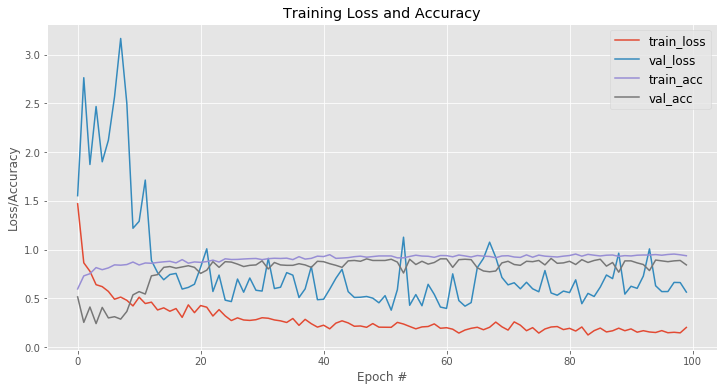

In [38]:
# plot the training loss and accuracy
fig, ax = plt.subplots(1,1, figsize=(12,6))
N = EPOCHS
ax.plot(np.arange(0, N), H.history["loss"], label="train_loss")
ax.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
ax.plot(np.arange(0, N), H.history["acc"], label="train_acc")
ax.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend(loc="upper right", fontsize =12)
plt.show()